# Load and preprocessing images

1) tf.keras.preprocessing 을 사용하는 방법
  -> preprocessing.image_dataset.from.directory
  
2) tf.data를 사용하여 input pipeline을 직접 짜는 방법

3) TensorFlow Dataset에서 데이터셋 다운받는 방법

## Setup

In [7]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers
import pathlib
import matplotlib.pyplot as plt

In [8]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='flower_photos', 
                                   untar=True)
data_dir = pathlib.Path(data_dir)

228827136/228813984 [==============================] - 7s 0us/step


In [9]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


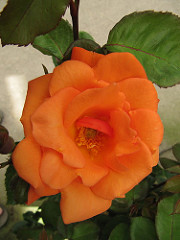

In [10]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

## 1) tf.keras.preprocessing 방법


In [11]:
batch_size = 32
img_height = 180
img_width = 180

In [12]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [13]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [14]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


Visualize the data

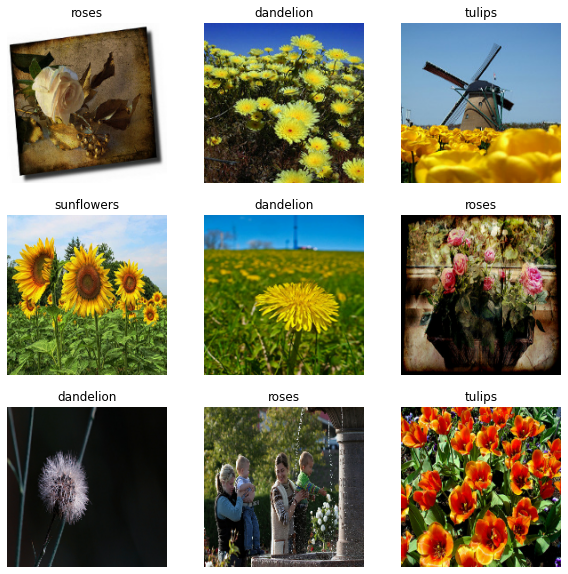

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [16]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


### Standardize the data

In [17]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [18]:
#방법 1
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.96902645


In [19]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Train a model

In [20]:
num_classes = 5

model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])


In [21]:
model.compile(
    optimizer='adam',
    loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['acc']
)

In [22]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
92/92 [==============================] - 38s 96ms/step - loss: 1.3123 - acc: 0.4394 - val_loss: 1.1100 - val_acc: 0.5817
Epoch 2/3
92/92 [==============================] - 4s 47ms/step - loss: 1.0615 - acc: 0.5807 - val_loss: 1.0657 - val_acc: 0.5681
Epoch 3/3
92/92 [==============================] - 4s 45ms/step - loss: 0.9043 - acc: 0.6536 - val_loss: 0.9339 - val_acc: 0.6199


## 2) Using tf.data for finer control



In [35]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [36]:
for f in list_ds.take(5):
  print(f.numpy())

b'/root/.keras/datasets/flower_photos/sunflowers/4895720722_8247f2015b_n.jpg'
b'/root/.keras/datasets/flower_photos/dandelion/17189437699_a9171b6ae3.jpg'
b'/root/.keras/datasets/flower_photos/daisy/14372713423_61e2daae88.jpg'
b'/root/.keras/datasets/flower_photos/dandelion/9853885425_4a82356f1d_m.jpg'
b'/root/.keras/datasets/flower_photos/dandelion/14283011_3e7452c5b2_n.jpg'


In [37]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [38]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

Length of datasets..

In [39]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


-> 파일 경로를 (img,label)쌍으로 변환하는 함수 정의

In [40]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [44]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # resize the image
  return tf.image.resize(img, [img_height, img_width])

In [42]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

Dataset.map 이용하여 training, validation set 생성

In [45]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [46]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  0


우리가 원하는 것 3가지 

1) 이미지가 잘 섞이는 것

2) 배치가 잘 될것

3) 배치가 연간 가능한 만큼 할당되어 효율적으로 돌아가야 함

In [47]:
def configure_for_performance(ds):
  ds = ds.cache()                      #캐시
  ds = ds.shuffle(buffer_size=1000)   # 셔플
  ds = ds.batch(batch_size)             # 배치
  ds = ds.prefetch(buffer_size=AUTOTUNE) # prefetch
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

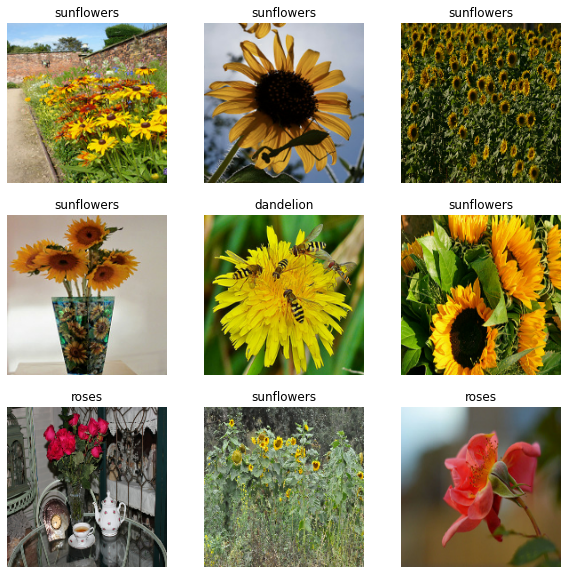

In [48]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

In [49]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
92/92 [==============================] - 11s 99ms/step - loss: 0.7635 - acc: 0.7132 - val_loss: 0.7125 - val_acc: 0.7207
Epoch 2/3
92/92 [==============================] - 5s 51ms/step - loss: 0.5987 - acc: 0.7851 - val_loss: 0.6466 - val_acc: 0.7493
Epoch 3/3
92/92 [==============================] - 5s 49ms/step - loss: 0.3936 - acc: 0.8658 - val_loss: 0.7783 - val_acc: 0.7221


## 3) TensorFlow Datasets 사용하기
이미 tensorflow에 구축이 되어있음(가장 간단함)

In [50]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]


Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [51]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


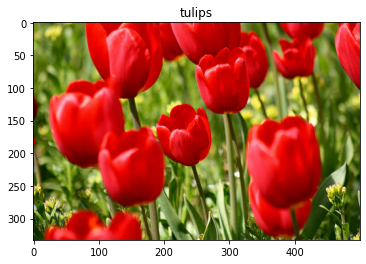

In [52]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [53]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)